In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2024-04-29 11:50:39--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-04-29 11:50:40--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  22.9MB/s    in 2m 38s  

2024-04-29 11:53:18 (21.4 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [ ]:
import  os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
from PIL import Image
from skimage.transform import resize

from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau

In [ ]:
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png  
  infl

In [ ]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [ ]:
img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,224,224)
    img_list.append(img_crop)
    img_low_list.append(resize(img_crop,(56,56)))

high_reso_imgs = np.array(img_list)  # Convert list to NumPy array
low_reso_imgs = np.array(img_low_list)  # Convert list to NumPy array

In [ ]:
os.chdir('/content')


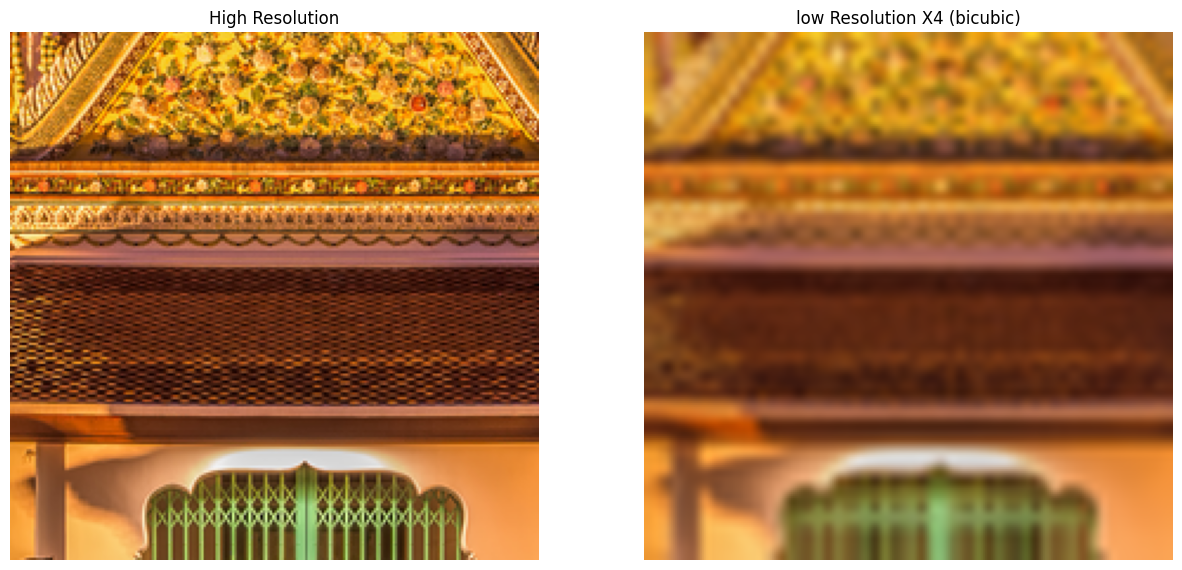

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2],(256,256),
                      interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')

In [ ]:
class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 64,lr_width = 64,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9)
        self.vgg = self.build_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)

            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)

            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])

            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])

            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)

    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)


    def build_vgg(self):
        # Your existing code to set up the VGG model
        base_vgg = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=self.shape_high_reso))
        model_output = base_vgg.layers[9].output
        vgg_model = Model(inputs=base_vgg.inputs, outputs=model_output)
        vgg_model.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return vgg_model

    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)

    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.nn.depth_to_space(x, scale))

    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)

        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)

        first_layer = PReLU()(first_layer)

        residual_blocks = self.residual_block(first_layer)

        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)

        output_residual = BatchNormalization(momentum=0.8)(output_residual)

        output_residual = Add()([output_residual,first_layer])

        upsample_layer = self.Upsample_Block(output_residual)

        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)

        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks,
                                             n_filters = (i+1)*2*n_filters)

        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self, optimizer):
        # Define inputs for the generator and discriminator
        dis_input = Input(shape=self.shape_high_reso)
        gen_input = Input(shape=self.shape_low_reso)

        # Generate high resolution outputs and features
        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)

        # Before integrating discriminator into the SRGAN model, set it to non-trainable
        self.discriminator.trainable = False
        for layer in self.discriminator.layers:
            layer.trainable = False

        # VGG is usually also set as non-trainable
        self.vgg.trainable = False
        for layer in self.vgg.layers:
            layer.trainable = False

        # Create the SRGAN model
        gan_model = Model(inputs=[gen_input, dis_input],
                          outputs=[generator_valid, generated_features])

        # Compile the SRGAN model
        gan_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-2, 1], optimizer=optimizer)
        gan_model.summary()

        return gan_model

    def train(self, epochs, save_interval = 100, batch_size = 16):
            pipeline = self.gen_pipeline(batch_size)
            vgg_pipeline = self.vgg_pipeline(batch_size)

            batch_count = self.samples // batch_size
            dlosses = []
            glosses = []
            for epo in range(1,epochs+1):
                print ('-'*15,'Epoch %d' % epo, '-'*15)
                for _ in tqdm(range(batch_count)):

                    ##########################

                    # Train the Discriminator

                    ##########################

                    # Generate Batch
                    hr_imgs, real, lr_imgs, fake = next(pipeline)

                    # Generate high resolution photos from low resolution photos
                    generated_hr_imags = self.generator.predict(lr_imgs)

                    # Train the discriminator
                    real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                    fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                    dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                    ##########################

                    # Train the Generator

                    ##########################

                    #Generate Batch
                    hr_imgs, lr_imgs, real = next(vgg_pipeline)

                    # Extract ground truth using VGG model
                    img_features = self.vgg.predict(hr_imgs)

                    gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


                if epo % save_interval == 0:
                  self.save_GAN_Model(epo)
                  self.plotLosses(dlosses,glosses,epo)
                dlosses.append(gan_loss[1])
                glosses.append(gan_loss[0])
                print('\n',dlosses[-1],glosses[-1])

In [ ]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')

        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')

    plt.savefig('predicted.png')

In [ ]:
model_srgan = SRGAN(lr_height=56, lr_width=56, channels=3, upscale_factor=4)

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 56, 56, 3)]          0         []                            
                                                                                                  
 model_2 (Functional)        (None, 224, 224, 3)          8979715   ['input_5[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 14, 14, 1)            3759681   ['model_2[0][0]']             
                           

--------------- Epoch 1 ---------------


<ipython-input-8-2b0bea3a04b0>:199: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(batch_count)):


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 0.2055308073759079 57.39546585083008
--------------- Epoch 2 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 0.18011577427387238 44.083980560302734
--------------- Epoch 3 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 0.17123271524906158 49.86453628540039
--------------- Epoch 4 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 0.18294838070869446 37.487464904785156
--------------- Epoch 5 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


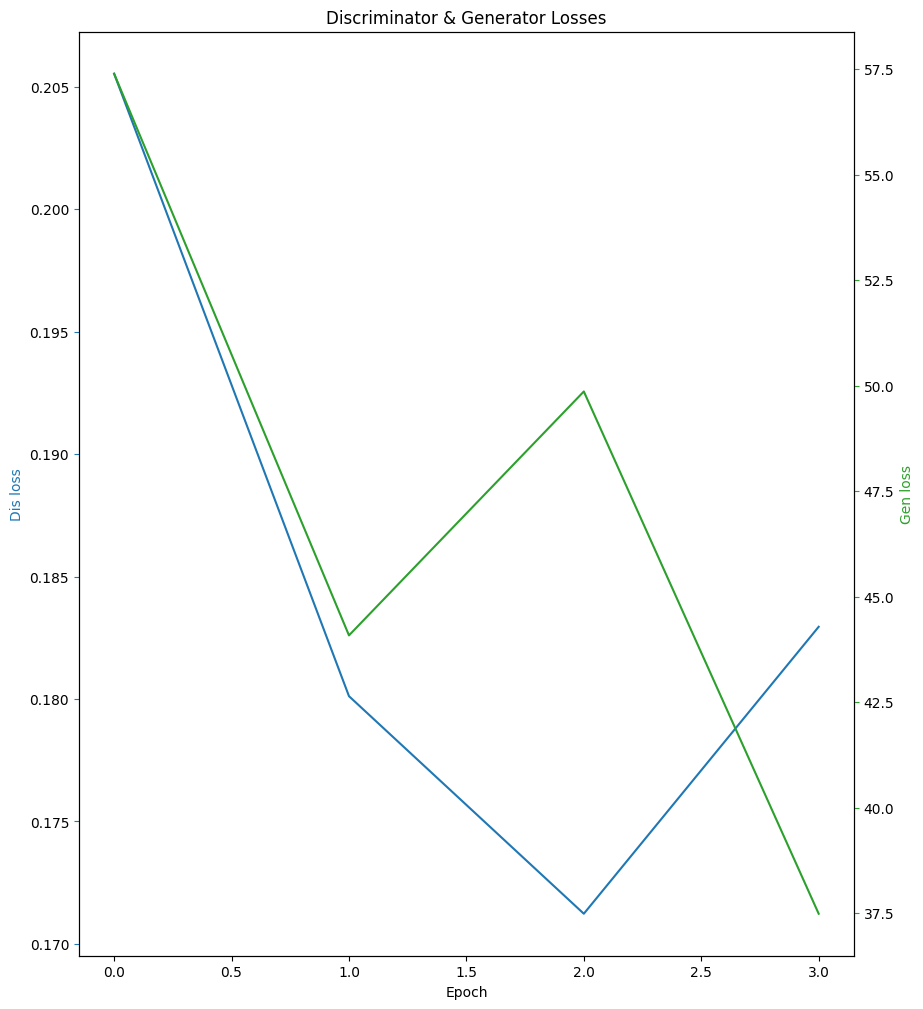


 0.16899719834327698 45.66230773925781
--------------- Epoch 6 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 0.1662696897983551 41.43672180175781
--------------- Epoch 7 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 0.1966148167848587 46.69605255126953
--------------- Epoch 8 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step

 0.2108137309551239 40.981407165527344
--------------- Epoch 9 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 0.20924650132656097 46.739990234375
--------------- Epoch 10 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


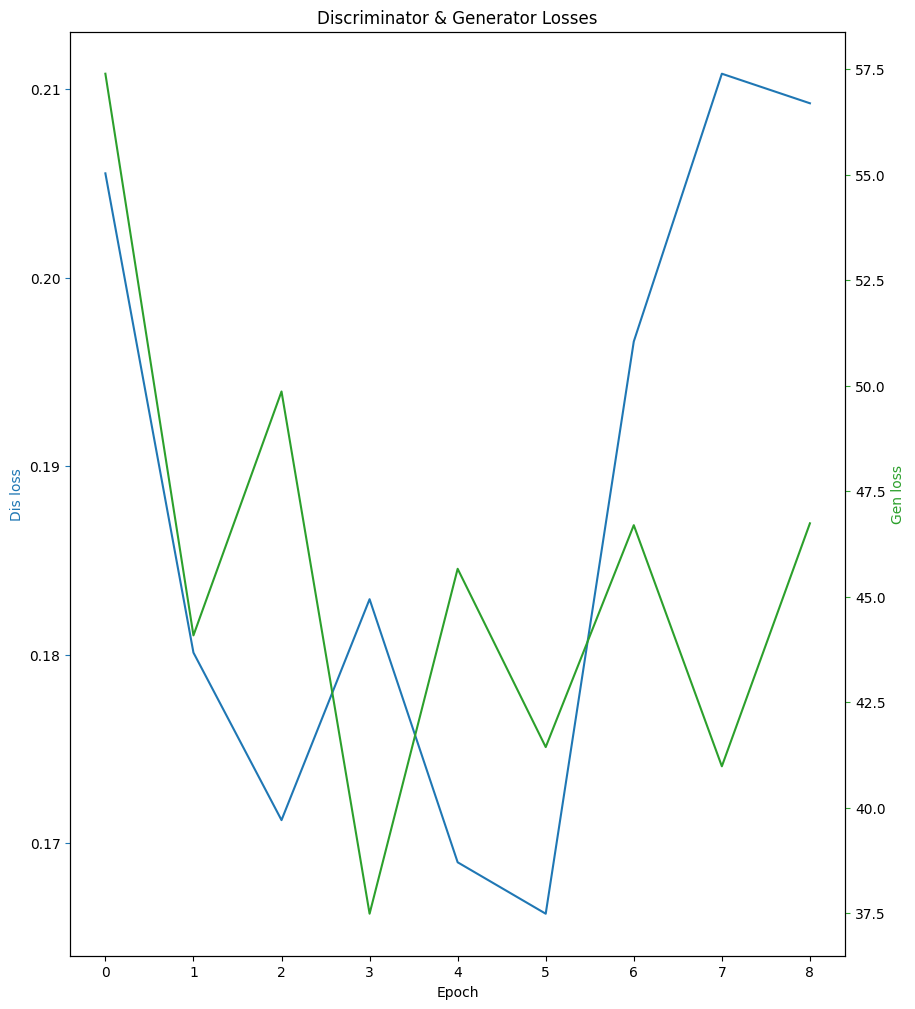


 0.3628814220428467 37.34693145751953
--------------- Epoch 11 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 0.2187732607126236 40.26348876953125
--------------- Epoch 12 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step

 0.34704145789146423 52.886741638183594
--------------- Epoch 13 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 0.4147092401981354 34.618404388427734
--------------- Epoch 14 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 0.5249274969100952 50.41037368774414
--------------- Epoch 15 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


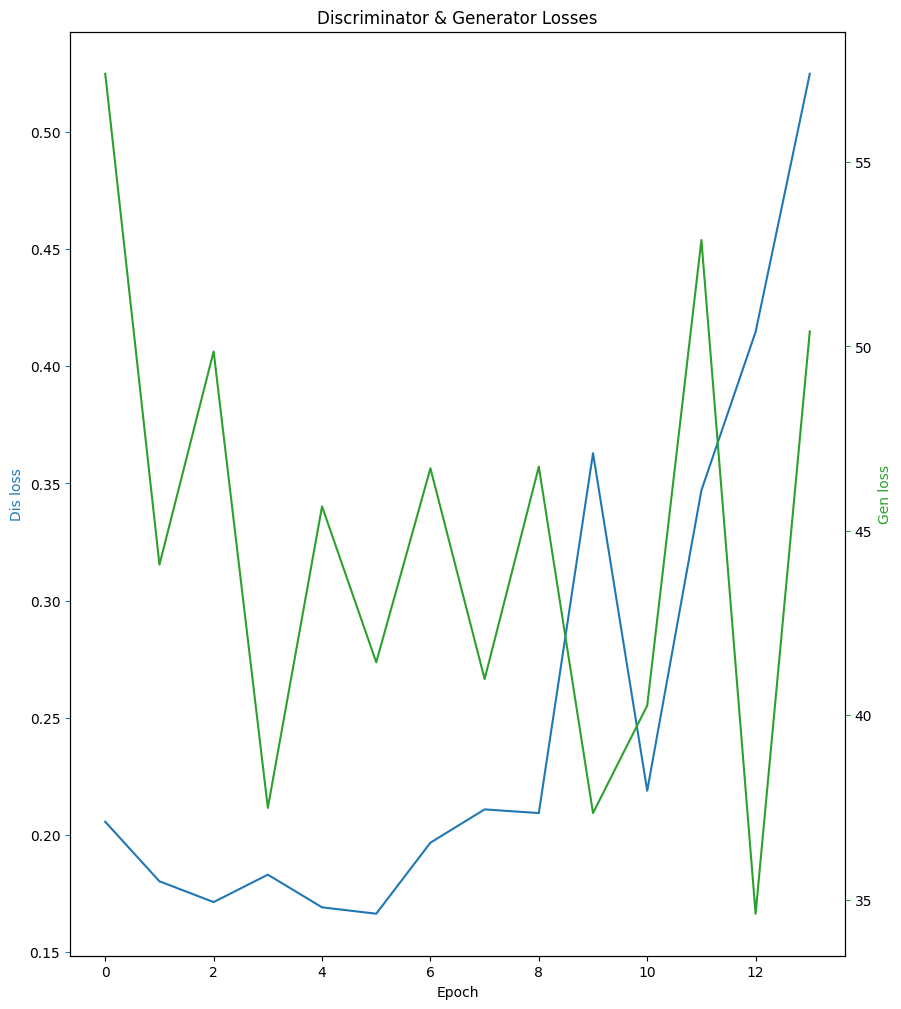


 0.8021486401557922 39.67071533203125
--------------- Epoch 16 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 0.7568778395652771 43.41367721557617
--------------- Epoch 17 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.0929009914398193 44.78327178955078
--------------- Epoch 18 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 0.8454521298408508 33.659603118896484
--------------- Epoch 19 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 0.9981006979942322 37.28806686401367
--------------- Epoch 20 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


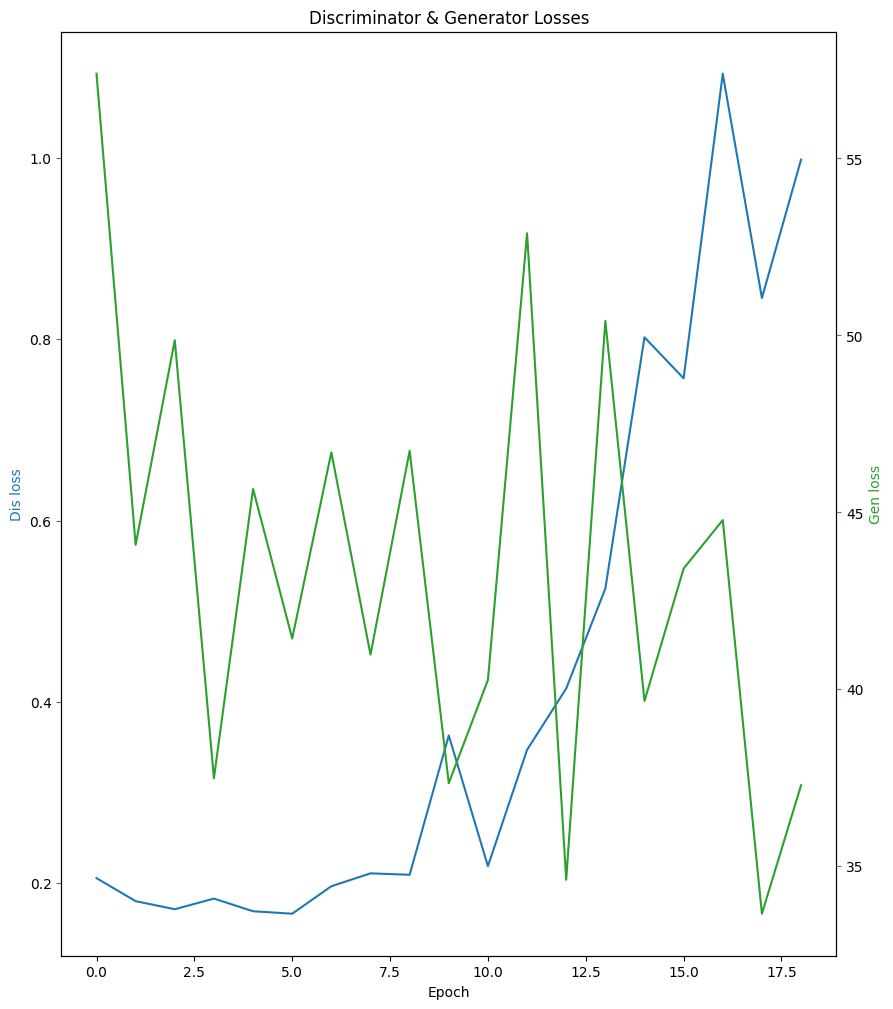


 1.8571288585662842 36.247230529785156
--------------- Epoch 21 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.4304231405258179 39.16501235961914
--------------- Epoch 22 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step

 0.8428993821144104 33.16899871826172
--------------- Epoch 23 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 0.8739280700683594 34.4989128112793
--------------- Epoch 24 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.0541040897369385 33.18440628051758
--------------- Epoch 25 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


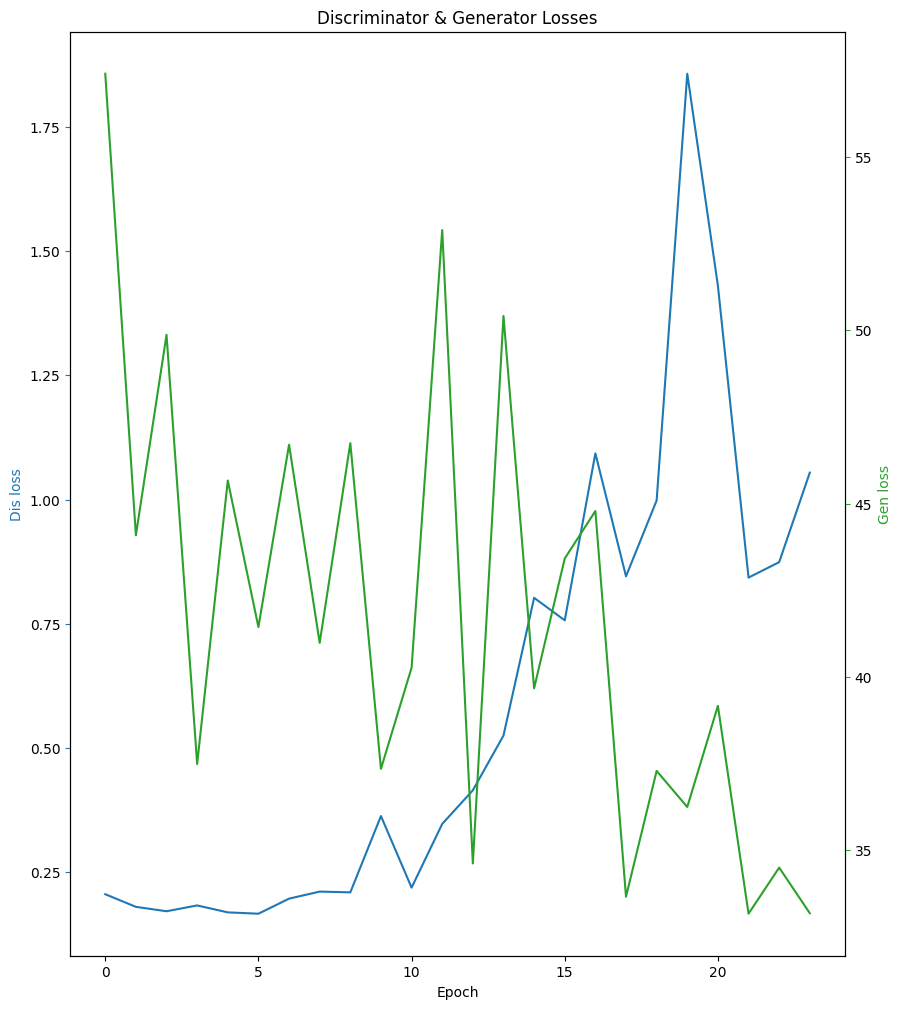


 1.0827440023422241 34.44816970825195
--------------- Epoch 26 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 1.0801535844802856 35.53893280029297
--------------- Epoch 27 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 1.173521637916565 37.60806655883789
--------------- Epoch 28 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 1.245498776435852 41.561038970947266
--------------- Epoch 29 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step

 1.442421793937683 28.467010498046875
--------------- Epoch 30 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


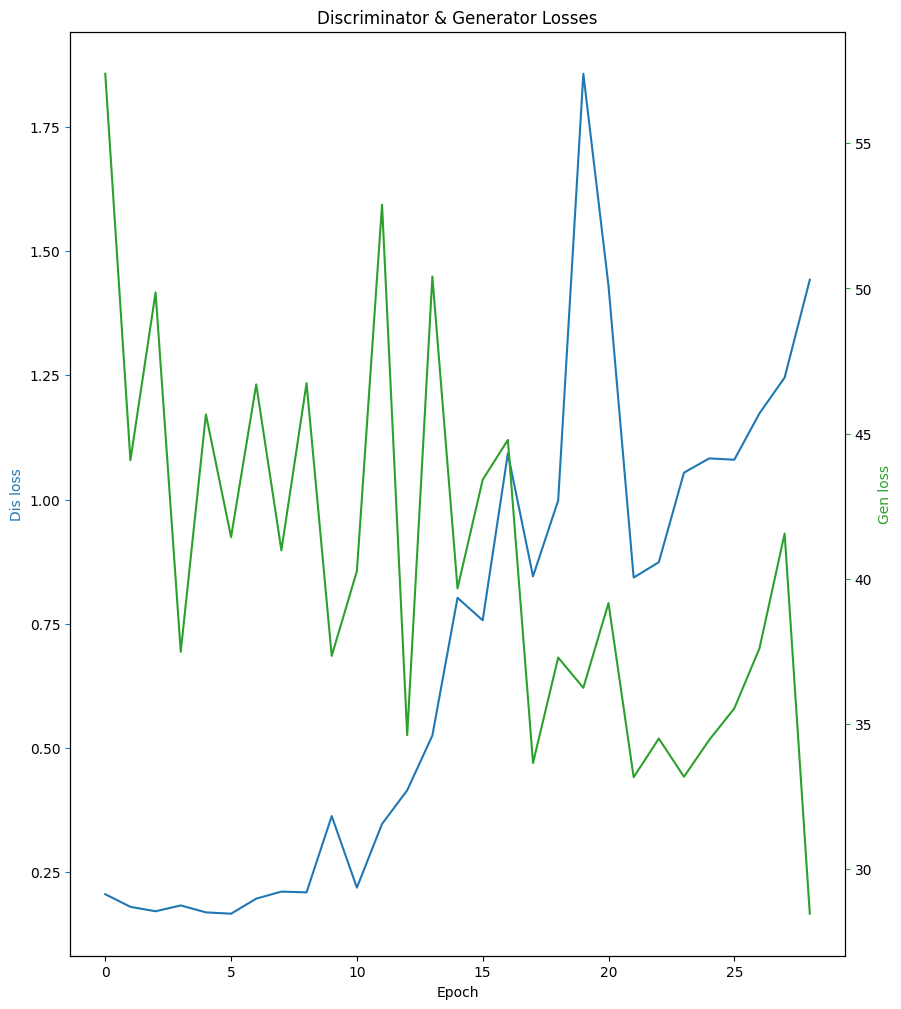


 1.410150170326233 31.3217830657959
--------------- Epoch 31 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 1.1560322046279907 29.260887145996094
--------------- Epoch 32 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 0.871934711933136 28.168685913085938
--------------- Epoch 33 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 1.5814467668533325 26.600460052490234
--------------- Epoch 34 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.2385129928588867 25.690427780151367
--------------- Epoch 35 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


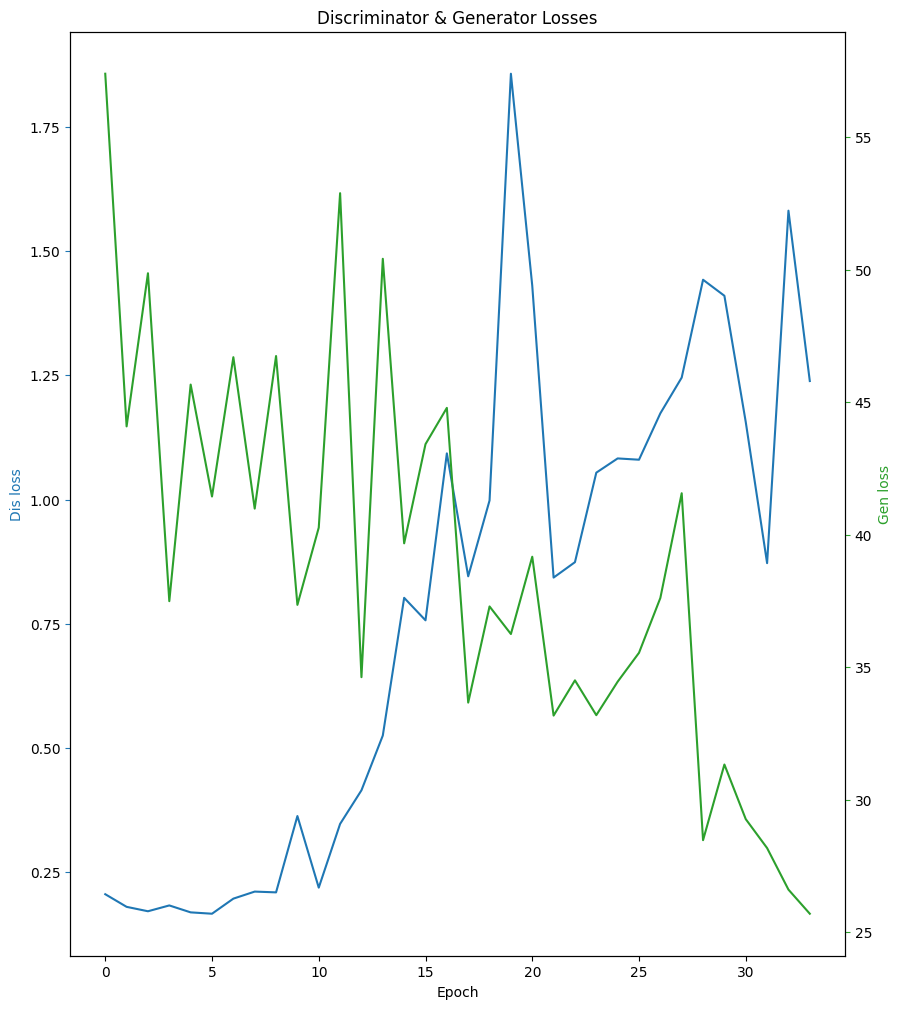


 1.121742606163025 26.413862228393555
--------------- Epoch 36 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.1571285724639893 34.40714645385742
--------------- Epoch 37 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 1.5563257932662964 24.69162940979004
--------------- Epoch 38 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.3796290159225464 25.809139251708984
--------------- Epoch 39 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step

 0.9879013895988464 24.619138717651367
--------------- Epoch 40 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


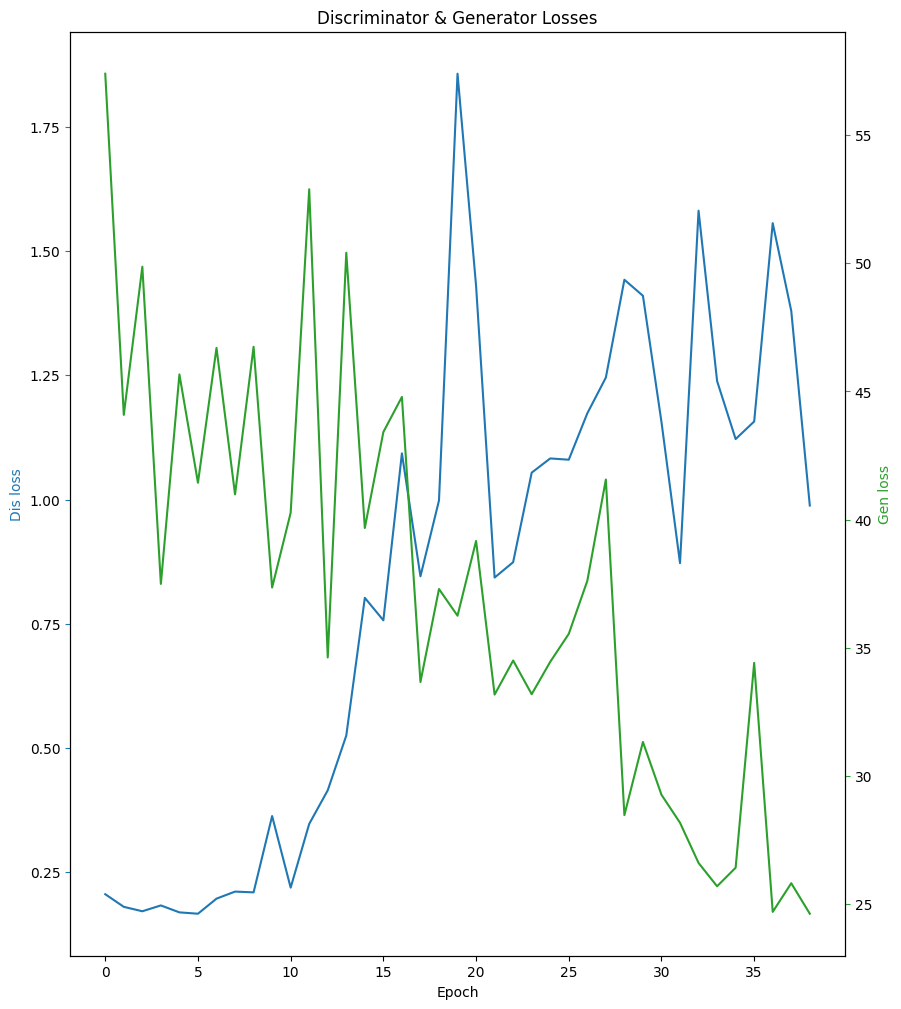


 1.3175617456436157 27.780738830566406
--------------- Epoch 41 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 1.170469880104065 26.49294662475586
--------------- Epoch 42 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 1.2669676542282104 28.625961303710938
--------------- Epoch 43 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step

 3.536931037902832 28.466476440429688
--------------- Epoch 44 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step

 1.9624272584915161 23.797311782836914
--------------- Epoch 45 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


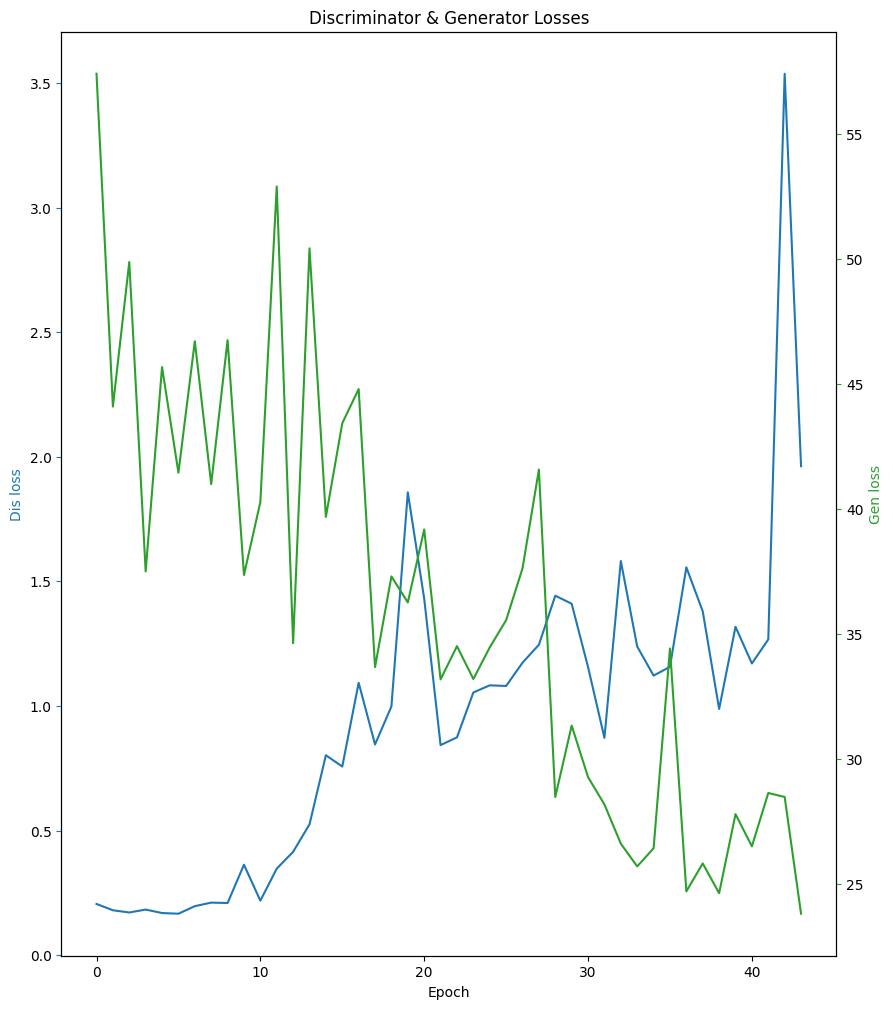


 1.9454092979431152 25.762065887451172
--------------- Epoch 46 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 1.7604984045028687 23.710302352905273
--------------- Epoch 47 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.365302324295044 22.240385055541992
--------------- Epoch 48 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.753079891204834 23.99375343322754
--------------- Epoch 49 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step

 1.5631810426712036 25.52564239501953
--------------- Epoch 50 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


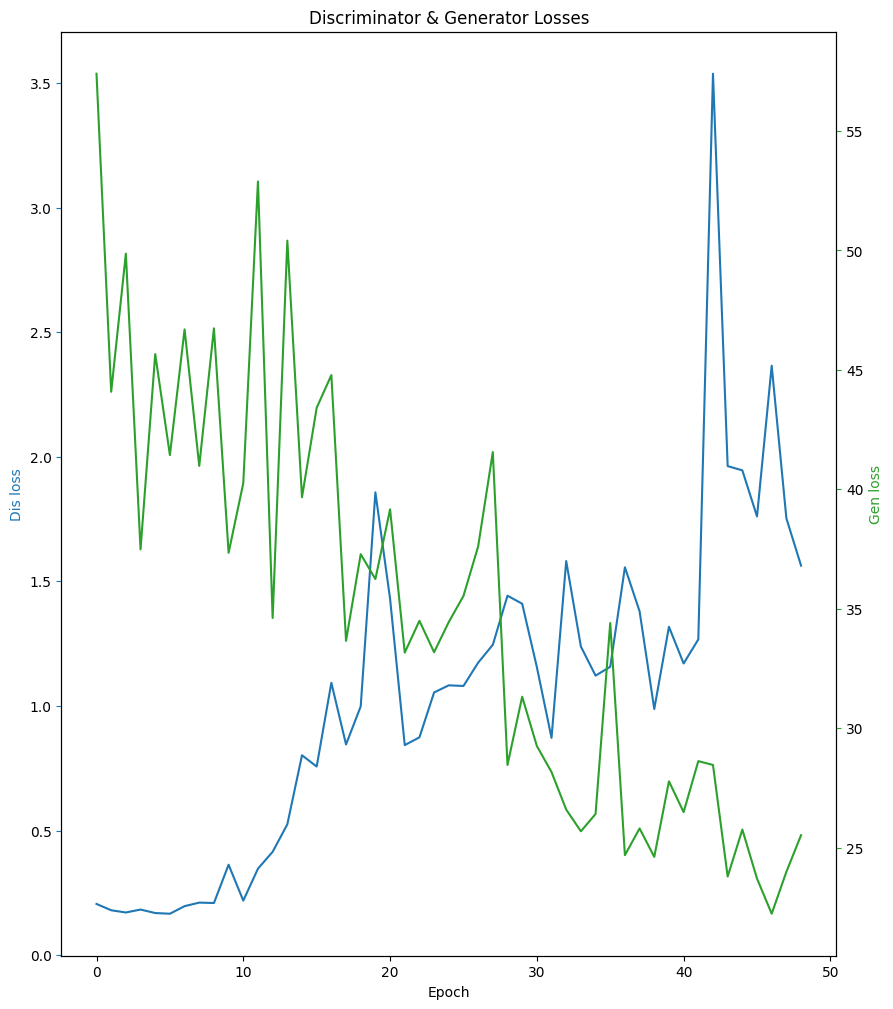


 1.854443907737732 20.33851432800293


In [ ]:
model_srgan.train(epochs=50, save_interval=5, batch_size=16)

In [ ]:
model_srgan.generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 56, 56, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 56, 56, 64)           15616     ['input_3[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 56, 56, 64)           200704    ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 56, 56, 64)           36928     ['p_re_lu[0][0]']             
                                                                                            

In [ ]:
model_srgan.discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                           

1/1 [==============================] - 1s 672ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


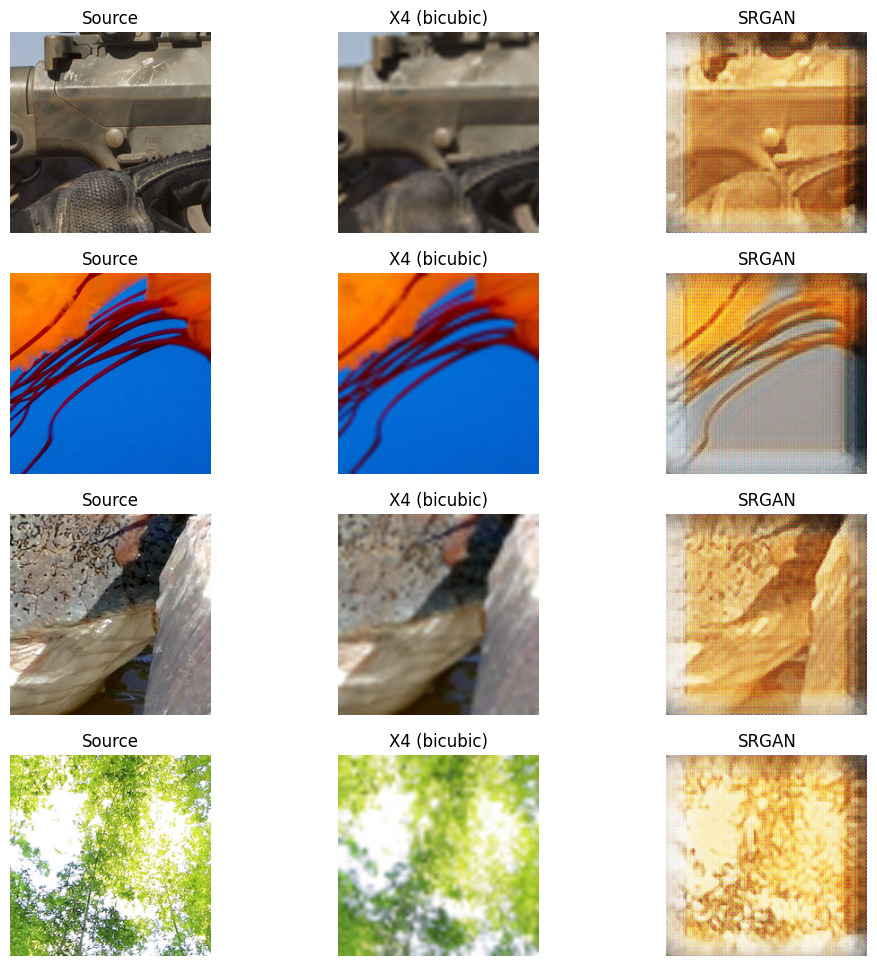

In [ ]:
plot_predict(low_reso_imgs, high_reso_imgs, model_srgan, n_imgs=4)

In [ ]:
os.chdir('/content')
!mkdir training_process
os.chdir('./training_process')

In [ ]:
shutil.move('/content/srgan_weights_epoch_50.h5', os.getcwd())

'/content/training_process/srgan_weights_epoch_50.h5'

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_50.h5')
model_srgan.train(50, save_interval=20 ,batch_size=16)

--------------- Epoch 1 ---------------


<ipython-input-8-2b0bea3a04b0>:199: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(batch_count)):


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.1120762825012207 23.35988426208496
--------------- Epoch 2 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 2.253460645675659 17.29991340637207
--------------- Epoch 3 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 1.5547667741775513 25.41722869873047
--------------- Epoch 4 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 1.4164742231369019 20.146881103515625
--------------- Epoch 5 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.1093783378601074 21.161907196044922
--------------- Epoch 6 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step

 1.4226620197296143 24.652311325073242
--------------- Epoch 7 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 1.3413506746292114 25.43547821044922
--------------- Epoch 8 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


In [ ]:
# Load pretrained model
model_srgan.srgan.load_weights('srgan_weights_epoch_50.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)